In [2]:
import pickle
from math import floor
from IPython.display import display, clear_output
import scipy.stats
from pylab import * 
from collections import OrderedDict
import numpy as np
import seaborn as sns
import pandas
from itertools import product as iterproduct, groupby, chain
%matplotlib inline
%run "/home/ibis/gregor.sturm/nanopore/own/notebooks/05_MAP006-basecaller/lib/analysis_lib.ipynb"
sns.set_style("ticks", {"axes.grid" : True, "grid.color" : ".95"})
matplotlib.rcParams.update({'font.size': 16})

In [3]:
# args = {
#     "true_events": "/home/ibis/gregor.sturm/nanopore/own/notebooks/03_pipeline/david_alignment_true_events.pickle",
#     "ref": "/home/ibis/gregor.sturm/nanopore/david_eccles_bc_ideas/mouse_ref.fa",
# }

# args = {
#     "true_events": "/home/ibis/gregor.sturm/nanopore/own/notebooks/03_pipeline/lambda_alignment.62pA_true_events.pickle",
#      "ref": "/home/ibis/gregor.sturm/nanopore/own/notebooks/03_pipeline/lambda_ref.fasta",
# #     "ref": "/home/sturm/Downloads/lambda_ref.fasta"
# }

args = {
    "true_events": "/home/ibis/gregor.sturm/nanopore/own/notebooks/05_MAP006-basecaller/loman006-1_100.alignment_true_events.pickle",
     "ref": "/home/ibis/gregor.sturm/nanopore/NanoporeData/PublicData/LomanLab_MAP-006/ecoli_mg1655.fa",
    "model" : "/home/ibis/gregor.sturm/nanopore/own/notebooks/05_MAP006-basecaller/loman006-1.model.computed.pickle",
#     "model" : "/home/ibis/gregor.sturm/nanopore/own/notebooks/05_MAP006-basecaller/ibislambda.model.pickle"
#     "ref": "/home/sturm/Downloads/lambda_ref.fasta"
}

In [4]:
NMER = 6
CONTEXT = 100
MEAN = 59

In [5]:
!pwd

/home/ibis/gregor.sturm/nanopore/own/notebooks


In [6]:
true_events = pickle.load(open(args["true_events"], 'rb'))

In [7]:
HMM_PARAMS = pickle.load(open(args["model"], 'rb'))
HMM_PARAMS = HMM_PARAMS["/opt/chimaera/model/r7.3_e6_70bps_6mer/template_median68pA.model"]

In [8]:
ref = load_ref(args["ref"])

['>gi|556503834|ref|NC_000913.3| Escherichia coli str. K-12 substr. MG1655, complete genome']
AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTGTGGATTAAAAAAAGAGTGTCTGATAGCAGCTTCTGAACTGGTTACCTGCCGTGAGTAAAT


In [9]:
def _get_context(event, start, end):
    """get the nt-context around the kmer. 
    E.g. start=-20: get context 20nt before the reference point
    (mid of kmer)"""
    ref_pos = event["ref_position"]
    start = ref_pos + start
    end = ref_pos + end
    context = ref[start:end]
    
    if len(context) != end-start:
        print(start, end, len(ref), len(context), end-start)
        raise IndexError
    else: return context

def get_context_before(event, n):
    """get n nucleotides before the start of the kmer"""
    length = len(event["kmer"])
    offset = 0
    return _get_context(event, -n+offset, offset)
    
def get_context_after(event, n):
    length = len(event["kmer"])
    offset = length
    return _get_context(event, offset, offset+n)

In [10]:
test_event = true_events[2000]
print(test_event['kmer'], _get_context(test_event, 0,6))
assert test_event['kmer'] == _get_context(test_event, 0, 6), "invalid reference"
assert (get_context_before(test_event, 20) 
        + test_event['kmer'] 
        + get_context_after(test_event, 20)) == (
    _get_context(test_event, -20, 26))

CGCAGG CGCAGG


## Analysis 

In [11]:
all_kmers = mk_kmer_dict(NMER)
ev_map = mk_event_map(true_events, all_kmers)

In [12]:
def prepare_events(kmer):
    template_events = [ev for ev in ev_map[kmer] if not np.isnan(ev["template.mean"])]
    template_events = [ev for ev in template_events if 
                   ev["ref_position"] > CONTEXT+NMER+1 and ev["ref_position"] < len(ref)-CONTEXT-NMER-1]
    print("kmer {0}".format(kmer))
    print(">>genomic_positions {0}".format(len(set([ev["ref_position"] for ev in template_events]))))
    print(">>total_events {0}".format(len(template_events)))
    return template_events

In [13]:
template_events = [prepare_events(kmer) for kmer in all_kmers]

kmer AAAAAA
>>genomic_positions 18
>>total_events 20
kmer AAAAAC
>>genomic_positions 49
>>total_events 52
kmer AAAAAG
>>genomic_positions 21
>>total_events 24
kmer AAAAAT
>>genomic_positions 29
>>total_events 29
kmer AAAACA
>>genomic_positions 42
>>total_events 56
kmer AAAACC
>>genomic_positions 67
>>total_events 81
kmer AAAACG
>>genomic_positions 98
>>total_events 121
kmer AAAACT
>>genomic_positions 49
>>total_events 63
kmer AAAAGA
>>genomic_positions 31
>>total_events 37
kmer AAAAGC
>>genomic_positions 40
>>total_events 43
kmer AAAAGG
>>genomic_positions 18
>>total_events 22
kmer AAAAGT
>>genomic_positions 22
>>total_events 23
kmer AAAATA
>>genomic_positions 65
>>total_events 75
kmer AAAATC
>>genomic_positions 63
>>total_events 74
kmer AAAATG
>>genomic_positions 70
>>total_events 81
kmer AAAATT
>>genomic_positions 43
>>total_events 53
kmer AAACAA
>>genomic_positions 46
>>total_events 56
kmer AAACAC
>>genomic_positions 46
>>total_events 60
kmer AAACAG
>>genomic_positions 90
>>total_ev

## Sequence context

In [26]:
context = (-20, 26)
context_buckets = [{nt: [] for nt in NTS} for _ in range(*context)]

In [27]:
for kmer_evs in template_events: 
    if len(kmer_evs) == 0: continue
    param_mean = float(HMM_PARAMS[HMM_PARAMS["kmer"] == kmer_evs[0]["kmer"]]["level_mean"])
    for ev in kmer_evs:
        nt_context = _get_context(ev, *context)
        diff = ev["template.mean"]
        if not np.isnan(diff):
            for i, pos in enumerate(range(*context)): 
                context_buckets[i][nt_context[i]].append(diff)


### assess significance

In [28]:
pvalue = [{nt: [] for nt in NTS} for _ in range(*context)]
criterion = 0.05 / len(range(*context))

In [29]:
for nt in NTS:
    for i, pos in enumerate(range(*context)): 
        pvalue[i][nt] = scipy.stats.ttest_1samp(context_buckets[i][nt], 0.0).pvalue

### plot

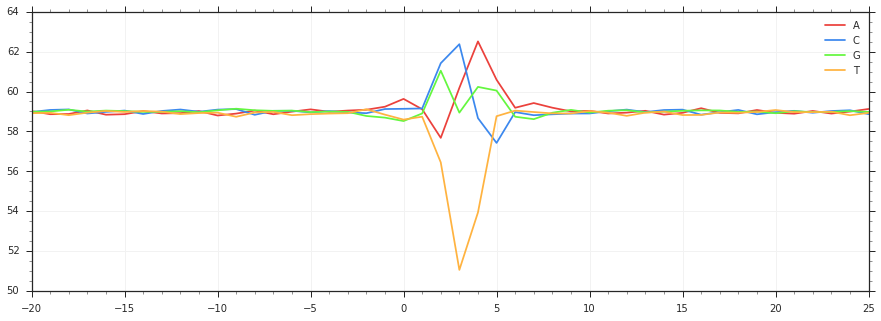

In [30]:
fig, ax1 = subplots(1, 1, figsize=(15, 5))

for nt in NTS:
    ax1.plot(range(*context), [median(pos[nt]) for pos in context_buckets], color=NT_COLORS[nt], label=nt)
ax1.legend()
ax1.minorticks_on()



## Dwell time

In [36]:
context = (-20, 26)
context_buckets = [{nt: [] for nt in NTS} for _ in range(*context)]

In [37]:
for kmer_evs in template_events: 
    if len(kmer_evs) == 0: continue
    for ev in kmer_evs:
        nt_context = _get_context(ev, *context)
        for i, pos in enumerate(range(*context)): 
            diff = ev["template.end"] - ev["template.start"]
            if not np.isnan(diff):
                context_buckets[i][nt_context[i]].append(diff)

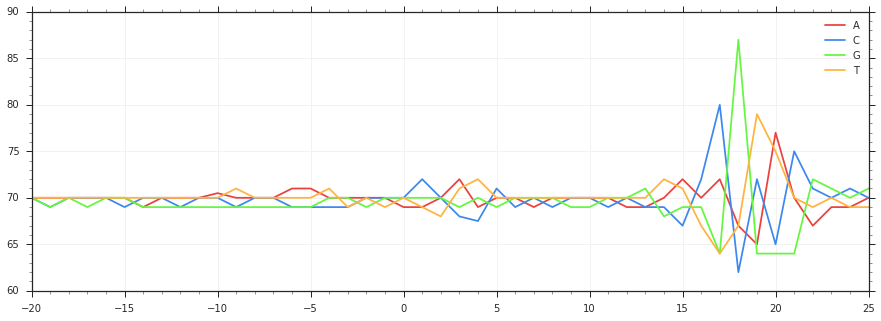

In [38]:
fig, ax = subplots(figsize=(15, 5))
for nt in NTS:
    ax.plot(range(*context), [median(pos[nt]) for pos in context_buckets], color=NT_COLORS[nt], label=nt)
ax.legend()
ax.minorticks_on()

In [40]:
dwelltimes =  {kmer: [] for kmer in mk_kmer_dict(5)}
for kmer_evs in template_events: 
    if len(kmer_evs) == 0: continue
    for ev in kmer_evs:
        dwell_kmer = _get_context(ev, 17, 22)        
        time = ev["template.end"] - ev["template.start"]
        dwelltimes[dwell_kmer].append(time)

In [47]:
def sorted_boxplot(ordered_dict, ylim=None):
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1})
    map2 = OrderedDict(sorted(ordered_dict.items(), key=lambda x : 0 if len(x[1]) == 0 else np.median(x[1])))
    fig, ax = subplots(figsize = (15, 5))
    boxplot(list(map2.values()))
    ax.set_xticklabels(list(map2.keys()), rotation=90, fontsize=8)
    if ylim is not None:
        ax.set_ylim(ylim)
    fig.show()

/home/ibis/gregor.sturm/bin/anaconda3/lib/python3.4/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


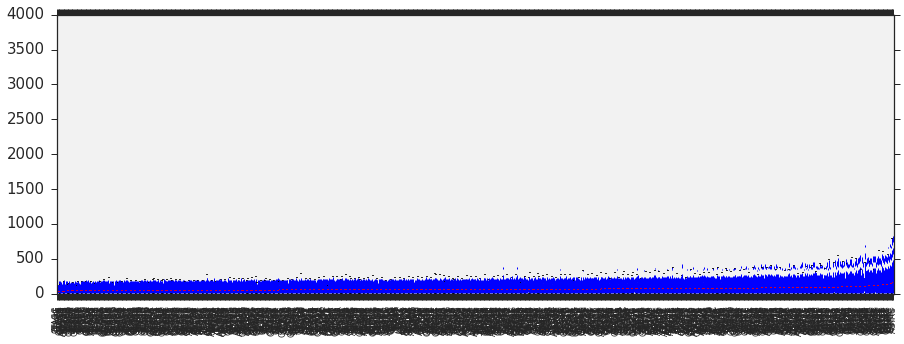

In [48]:
sorted_boxplot(dwelltimes)